# Импортируем phout и считаем по нему разное

In [1]:
# подключаем библиотеки
%matplotlib inline
import json
import os
import glob
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

base_path = "/Users/admin/Documents/net1/tests/loadtests"

def path_logs(folder):
    all_subdirs = [os.path.join(base_path, folder, d) for d in os.listdir(os.path.join(base_path, folder)) if os.path.isdir(os.path.join(base_path, folder, d))]
    latest_subdir = max(all_subdirs, key=os.path.getmtime)
    return glob.glob(latest_subdir + '/phout_*.log')[0], latest_subdir + '/monitoring.log'

In [2]:
def request_graph(path_to_log):
    # импортируем пхаут
    phout_columns = [
        'time', 'tag', 'interval_real',
        'connect_time', 'send_time',
        'latency', 'receive_time',
        'interval_event', 'size_out',
        'size_in', 'net_code', 'proto_code']
    data = pd.read_csv(
        path_to_log,
        sep='\t', names=phout_columns)
    # хитрые манипуляции с колонками:
    # высчитываем время получения - будем группировать по нему (заводим новую колонку)
    data['ts'] = data.time + data.interval_real / 1000000
    # округляем до секунды
    data['receive_sec'] = data.ts.astype(int)
    # и индексируем по этой секунде
    data.set_index(['receive_sec'], inplace=True)
    # для удобства посчитаем респонс тайм в миллисекундах
    data['rt_ms'] = data.interval_real / 1000
    # группируем по индексу, считаем и рисуем график
    data[:10]
    data.groupby(level=0).count().time.plot(title="RPS")
    plt.show()
    # группируем по индексу, считаем разные агрегаты и рисуем график
    data.groupby(level=0).rt_ms.agg([np.mean, np.std, np.median]).plot(title='delay')
    plt.show()
    data = data.proto_code.groupby(level=0).value_counts()
    data = data.unstack(level=1).fillna(0)
    data.plot(title='http codes')
    plt.show()

def system_graph(path_to_log):
    columns = ['timestamp', 'memory_used', 'num_fd', 'cpu']
    data = []
    with open(path_to_log) as f:
        for line in f:
            if line == "[]\n":
                continue
            raw = json.loads(line)[0]
            timestamp = raw['timestamp']
            memory_used = float(list(raw['data'].values())[0]['metrics']['Memory_used']) / 10**6
            num_fd = list(raw['data'].values())[0]['metrics']['custom:None']
            cpu = 100 - list(raw['data'].values())[0]['metrics'].get('custom:cpu-cpu-total_usage_idle', 100.)
            data.append([timestamp, memory_used, num_fd, cpu])
    data = pd.DataFrame(data=data, columns=columns)
    data.set_index(['timestamp'], inplace=True)
    for i in columns[1:]:
        data[i].plot(title=i)
        plt.show()

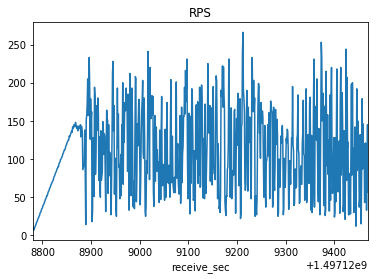

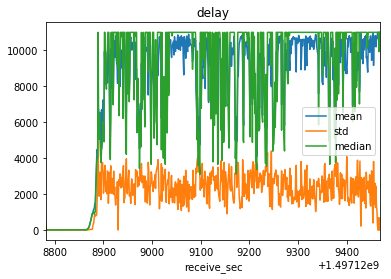

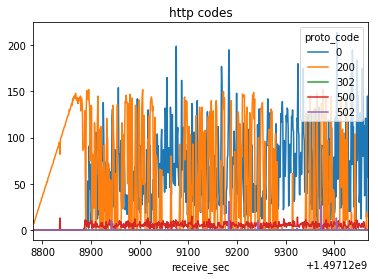

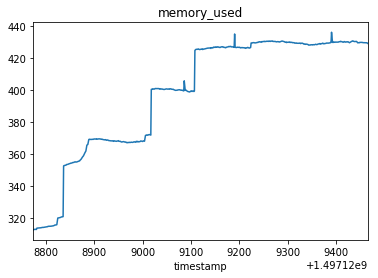

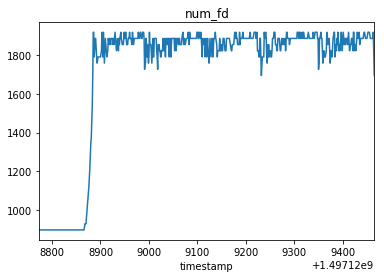

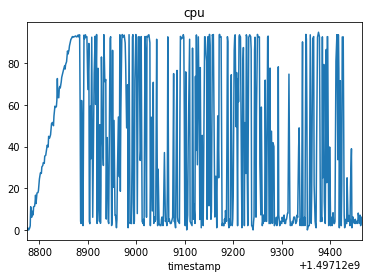

In [3]:
# authorisation sha256
a, b = path_logs('authsha256')
request_graph(a)
system_graph(b)

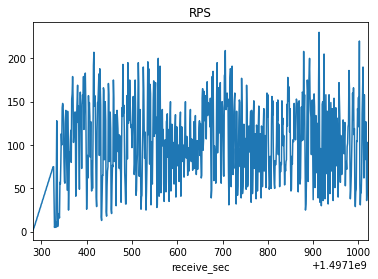

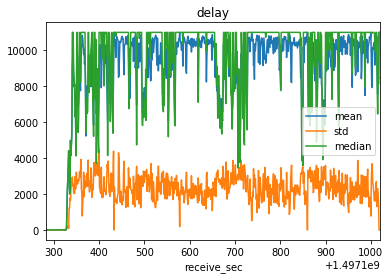

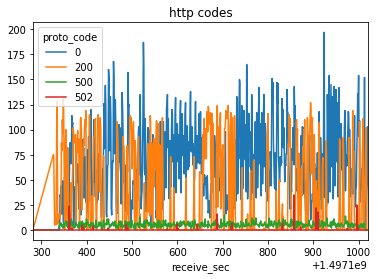

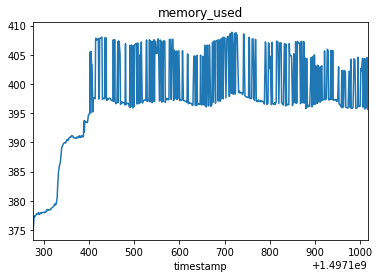

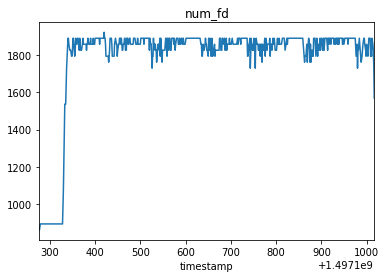

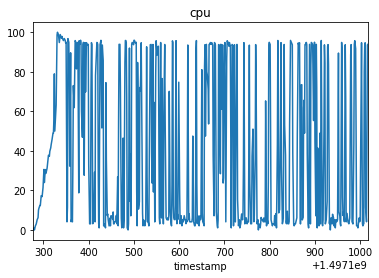

In [4]:
# authorisation pbkdf2
a, b = path_logs('authpbkdf2')
request_graph(a)
system_graph(b)

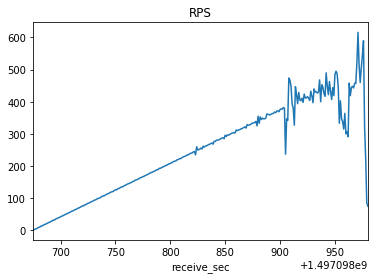

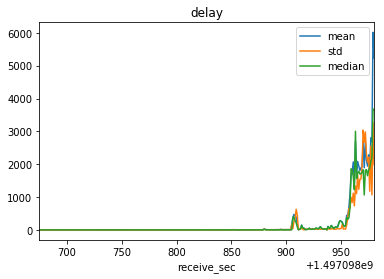

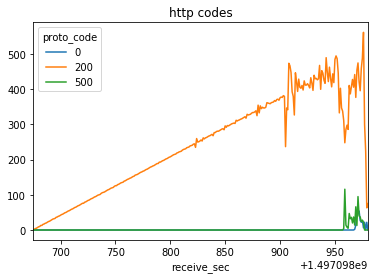

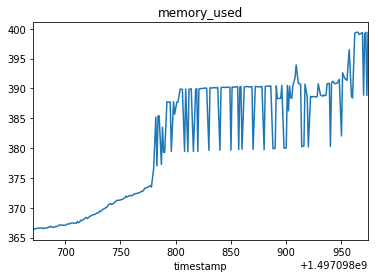

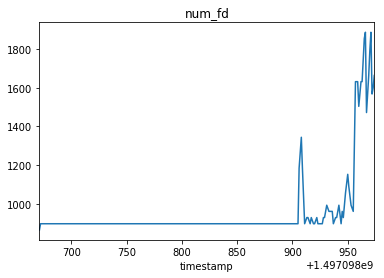

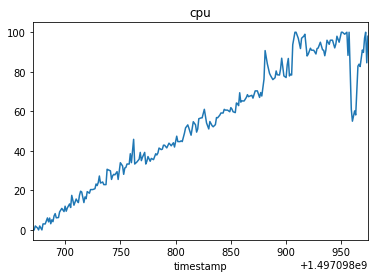

In [5]:
# calc
a,b = path_logs('calc')
request_graph(a)
system_graph(b)

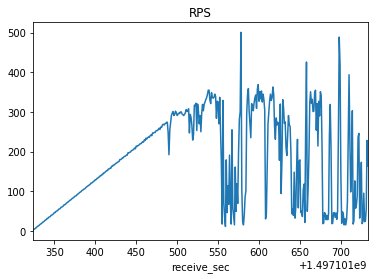

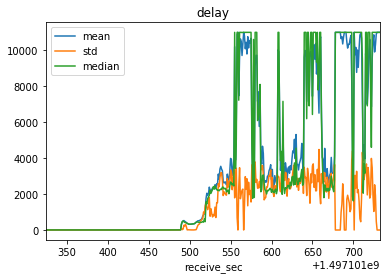

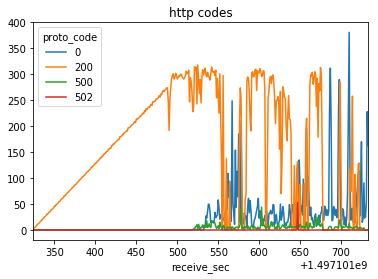

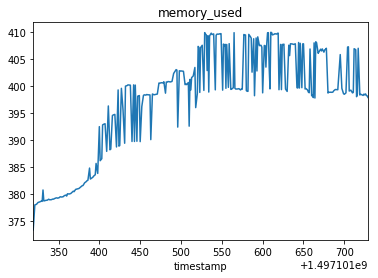

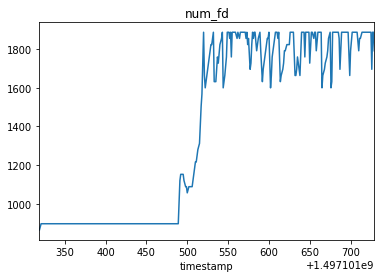

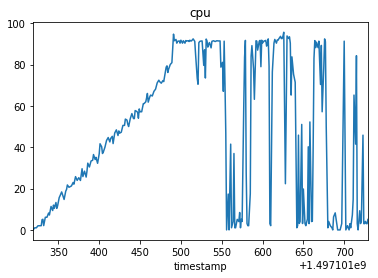

In [6]:
# fast
a,b = path_logs('fast')
request_graph(a)
system_graph(b)

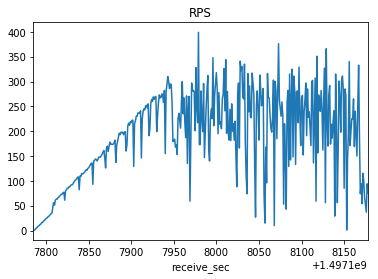

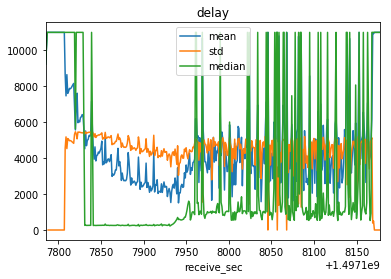

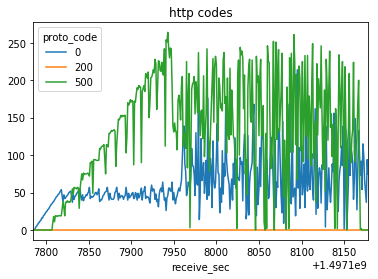

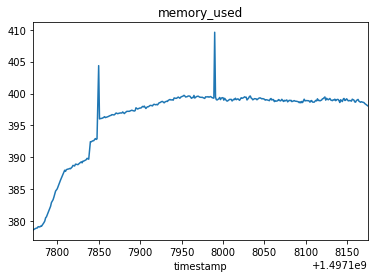

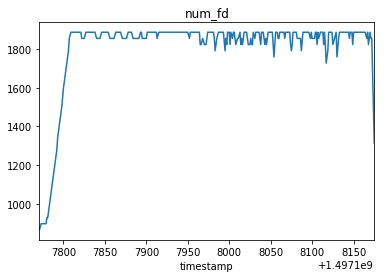

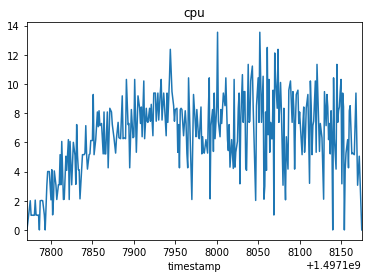

In [7]:
# ping
a,b = path_logs('ping')
request_graph(a)
system_graph(b)

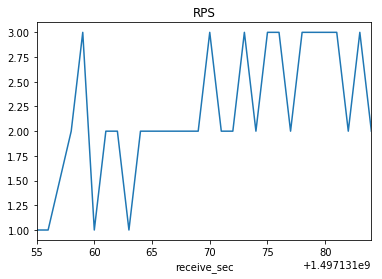

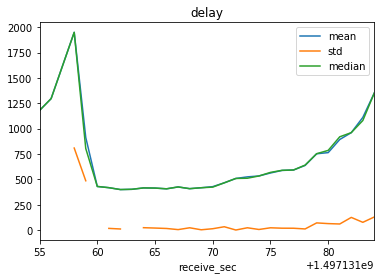

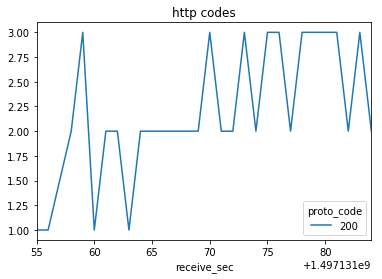

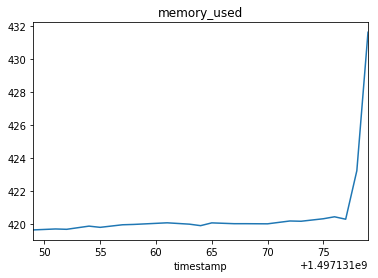

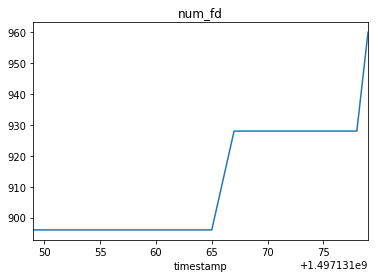

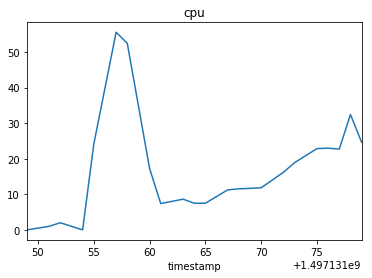

In [8]:
# nginx
a,b = path_logs('bigfiles80')
request_graph(a)
system_graph(b)

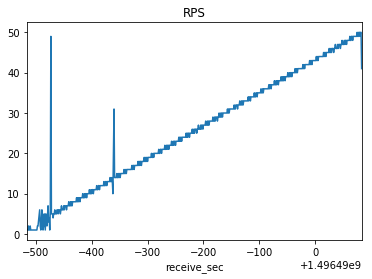

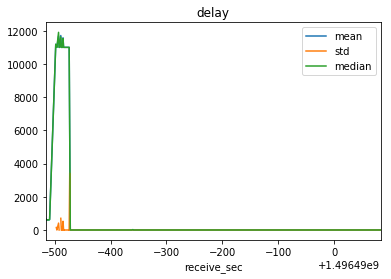

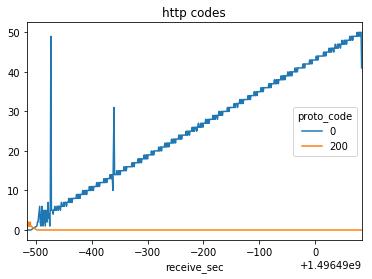

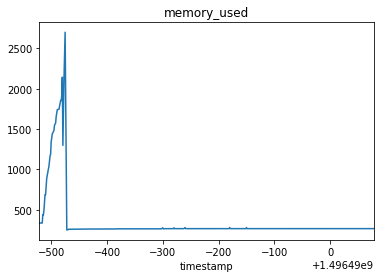

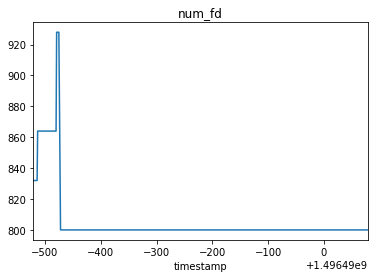

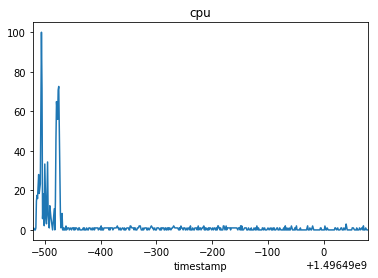

In [9]:
# server
a,b = path_logs('bigfiles8080')
request_graph(a)
system_graph(b)

## Сравнение методов шифрования паролей sha256 и pbkdf2

Координальной разницы не выявлено. При этом, при использовании sha2 сервер вернул больше ответов с кодом 200, а также
на сервере было меньше всплесков потребелния ОЗУ и ЦПУ.

## Нагрузка на "быструю" функцию приложения
Здесь имеет место быть ряд ограничивающи факторов, основные из которых - использование redis в качестве БД, 
yandex-tank для тестирования а также выделение всего одного ядра виртуальной машине. Проявляется это в следующих факторах:
    1) из-за использования redis не удалось выполнять запросы к бд; разве что получение значения по ключу, который 
    присылает клиент, и передача его в ответе;
    2) из-за использования yandex-tank тесты получились слигшком однообразными (выполнялся всегда один и тот же запрос)
В результате того, что redis был запущен локально и он не писал на диск ничего, ответ всегда получался крайне быстро,
и бутылочным горлышком стал сам сервер.
Все вышеперечисленое выражается в том, что тест не смог до конца нагрузить сервер&

## Нагрузка на "вычислительную" функцию приложения
На графиках хорошо видно, что все показатели растут сначала линейно, а потом, ближе к концу, когда ЦПУ оказался 
перегружен, посыпались и ответы, с отличным от 200 кодом. Связано это с тем, что ОС приходилось принимать решение, 
какой из задач заниматьяс в данный моент (напоминаю, что виртуальной машине было выдано только одно ядро)

## Нагрзука на "медленную" функцию приложения
По поводу данного теста мне нечего сказать, кроме того, что нагрузка на сервер возрастала пусть и почти линейно, но
с большим разбросом. Связано это, как мне кажется, с тем, что я вызываю команду ping с условиями -c 10 и -W 2, что
1) увеличивает нагрузку на сервер (каждый запуск данной генерирует 10 пинг запросов клиентом)
2) делает нагрузку менее равномерной и постонной (из-за чего и возникают скачки) (после 2 секунд отсутствия ответа 
функция прекращает свое выполнение, а сервер все еще обрабатывает предыдущий); также это заметно по очень 
резкому увеличнию числа файловых дескрипторов.

## Сранение nginx и самописного сервиса

Кроме как избиением младенецев это не назвать: на тесте по отдаче больших файлов мой сервис почти сразу перестал 
выдавать ответы с кодом 200 и в итоге с задачей не справился. Также хотелось бы выделить отдельно сравнение 
потребления памяти: в то время, как nginx справился с задачей, он потреблял примерно втрое меньше памяти. 
С нагрузкой на cpu ситуация та же. Разгром по всем фронтам.

## Заключение
1) При выборе способа шифрования паролей между sha256 и pbkdf2 первый выглядит предпочтительнее
2) При отдаче статики клиентам лучше использовать проверенный временем nginx
3) Написанному мной серверу срочно требуется оптимизация, а виртуальным машинам второе ядро.